# Score LDL variants for the HepG2 task
Look for variants that increase / decrease expression to explain mechanisms of disease, find causal variants, and predict the most pathogenic variants. Also a validation technique.

1. make bed file with appropriate regions
2. bedtools getfasta for the sequences
3. intialize model
4. convert to one hot
5. try all base pair changes (ISM)
6. compute deepLIFT scores

In [6]:
import os

basePath = '../../data/variants/peyton_gwas/expanded_LD_geno/rsq_0.8/grasp/'
phenotype = 'LDL_cholesterol'
os.system('mkdir ../variant_scoring/%s' % phenotype)
variantBed = open(basePath + phenotype + '_pruned_rsq_0.8_expanded_rsq_0.8.bed')
variantSequenceBed = open('../variant_scoring/%s/variants_sequence_context.bed' % phenotype, 'w')
associatedVariants = []
for line in variantBed:
    line = line.strip().split('\t')
    line[1] = str(int(line[1]) - 72)
    line[2] = str(int(line[2]) + 72)
    associatedVariants.append(line[3])
    variantSequenceBed.write('\t'.join(line) + '\n')
variantBed.close()
variantSequenceBed.close()

In [4]:
!bedtools getfasta -fi /scratch/users/rmovva/data/hg19.fa -bed ../variant_scoring/LDL_cholesterol/variants_sequence_context.bed -fo ../variant_scoring/LDL_cholesterol/variant_sequences.fa

In [70]:
import avutils.util
import deeplift
import deeplift.conversion.keras_conversion as kc
import numpy as np

modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

seqNames = []
seqStrings = []
with open('../variant_scoring/%s/variant_sequences.fa' % phenotype) as seqFile:
    i = 0
    for line in seqFile:
        line = line.strip()
        if i % 2 == 0:
            seqNames.append(line.split('>')[1] + ',' + associatedVariants[i/2])
        else:
            seqStrings.append(line)
        i += 1

import time
t0 = time.time()
seqs = np.array([avutils.util.seq_to_one_hot(seq) for seq in seqStrings]).astype(np.float32)
print("Converting seq strings to one-hot arrays took %.3f sec" % (time.time() - t0))
print seqs.shape

In [17]:
seqs = seqs.astype(np.float32)
seqsMutated = np.ndarray(shape=(4, seqs.shape[0], seqs.shape[1], seqs.shape[2]), dtype=np.float32)
for i in range(4):
    seqs[:, seqs.shape[1]/2] = np.zeros(4)
    seqs[:, seqs.shape[1]/2, i] = 1.0
    seqsMutated[i] = seqs

In [22]:
print seqs[0][72]
print seqsMutated[:, 0, 72, :]

[ 0.  0.  0.  1.]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


In [23]:
t0 = time.time()
refPreds = keras_model.predict(seqs, batch_size=200)
print("Computing reference predictions took %.3f sec" % (time.time() - t0))

Computing reference predictions took 34.718 sec


In [24]:
mutPreds = np.ndarray(shape=(4, seqs.shape[0], refPreds.shape[1]), dtype=np.float32)
t0 = time.time()
for i in range(len(mutPreds)):
    mutPreds[i] = keras_model.predict(seqsMutated[i], batch_size=200)
print("Computing mutated predictions took %.3f sec" % (time.time() - t0))

Computing mutated predictions took 138.671 sec


In [148]:
# hepg2_scores = np.max(np.abs(np.log2(mutPreds[:, :, 8]) - np.log2(refPreds[:, 8])), axis=0)
# k562_scores = np.max(np.abs(np.log2(mutPreds[:, :, 2]) - np.log2(refPreds[:, 2])), axis=0)
# hepg2_scores = np.log2(np.max(np.abs((mutPreds[:, :, 8] - refPreds[:, 8]) / refPreds[:, 8]), axis=0))
# k562_scores = np.log2(np.max(np.abs((mutPreds[:, :, 2] - refPreds[:, 2]) / refPreds[:, 2]), axis=0))
hepg2_scores = np.max(np.abs(mutPreds[:, :, 11] - refPreds[:, 11]), axis=0)
k562_scores = np.max(np.abs(mutPreds[:, :, 5] - refPreds[:, 5]), axis=0)

In [157]:
hepg2ScoresByTagSnp = {snp: [] for snp in set(associatedVariants)}
k562ScoresByTagSnp = {snp: [] for snp in set(associatedVariants)}
for (i, score) in enumerate(hepg2_scores):
    hepg2ScoresByTagSnp[associatedVariants[i]].append(hepg2_scores[i])
    k562ScoresByTagSnp[associatedVariants[i]].append(k562_scores[i])
hepg2MaxScoresByTagSnp = {snp: np.max(hepg2ScoresByTagSnp[snp]) for snp in hepg2ScoresByTagSnp}
k562MaxScoresByTagSnp = {snp: np.max(k562ScoresByTagSnp[snp]) for snp in k562ScoresByTagSnp}
hepg2SecondScoresByTagSnp = {snp: hepg2ScoresByTagSnp[snp][0] if len(hepg2ScoresByTagSnp[snp]) == 1 else np.sort(hepg2ScoresByTagSnp[snp])[::-1][1] for snp in hepg2ScoresByTagSnp}
k562SecondScoresByTagSnp = {snp: k562ScoresByTagSnp[snp][0] if len(k562ScoresByTagSnp[snp]) == 1 else np.sort(k562ScoresByTagSnp[snp])[::-1][1] for snp in k562ScoresByTagSnp}

In [160]:
print np.mean(hepg2_scores), np.std(hepg2_scores)
print np.mean(k562_scores), np.std(k562_scores)
print np.mean(hepg2MaxScoresByTagSnp.values()), np.std(hepg2MaxScoresByTagSnp.values())
print np.mean(k562MaxScoresByTagSnp.values()), np.std(k562MaxScoresByTagSnp.values())
hepg2Ratios = np.array(hepg2MaxScoresByTagSnp.values()) / np.array(hepg2SecondScoresByTagSnp.values())
k562Ratios = np.array(k562MaxScoresByTagSnp.values()) / np.array(k562SecondScoresByTagSnp.values())
print np.mean(hepg2Ratios), np.std(hepg2Ratios)
print np.mean(k562Ratios), np.std(k562Ratios)

0.0401165 0.0371062
0.0307385 0.0270016
0.0886967 0.083682
0.0657791 0.0587133
1.56748 1.31324
1.5424 1.32669


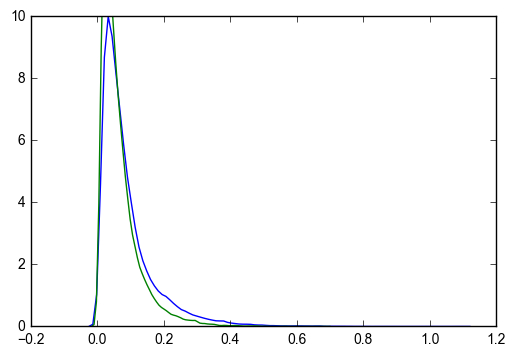

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(hepg2MaxScoresByTagSnp.values())
sns.kdeplot(k562MaxScoresByTagSnp.values())
plt.show()

In [131]:
print "HepG2"
print np.sort(hepg2_scores)[::-1][:10]
print np.argsort(hepg2_scores)[::-1][:10]
print np.sort(hepg2_scores)[:10]
print np.argsort(hepg2_scores)[:10]
print "K562"
print np.sort(k562_scores)[::-1][:10]
print np.argsort(k562_scores)[::-1][:10]
print np.sort(k562_scores)[:10]
print np.argsort(k562_scores)[:10]
print len(set(np.argsort(k562_scores)[::-1][:10]).intersection(np.argsort(hepg2_scores)[::-1][:10]))

HepG2
[ 1.29019952  1.20572996  1.06968939  1.04579473  1.03509963  0.97602427
  0.96438742  0.95192677  0.94532216  0.93639517]
[808722 231500 210803 621244 648508 414723 494358 631461 497844 566686]
[ 0.00023094  0.00027475  0.00048102  0.000528    0.000606    0.000606
  0.0006067   0.00060672  0.00063346  0.00067669]
[198935  87611 725309 516173 590269 590268  58069  92427 975889 730089]
K562
[ 1.17142379  1.15530252  1.01787317  0.9672491   0.95594156  0.94325411
  0.93980086  0.90893173  0.90420294  0.89360923]
[808722 231500 648508 621244 210803 497844 414723 528849 566686 494358]
[ 0.00036955  0.00052136  0.0005483   0.0006566   0.00089183  0.00104889
  0.00105584  0.00107908  0.00108552  0.00112133]
[ 50779 582144  53781  59562 469238 623531 445132 735473 822081 117239]
9


In [123]:
from scipy.stats import spearmanr

# sample = np.random.choice(np.arange(len(hepg2_scores)), 1000)

print spearmanr(k562_scores, hepg2_scores, nan_policy = 'omit')

SpearmanrResult(correlation=0.7652785229639244, pvalue=0.0)


In [127]:
variant_idxs = np.argsort(hepg2_scores)[::-1][:10]
for (i, variant_idx) in enumerate(variant_idxs):
    print(i+1)
    print hepg2_scores[variant_idx]
    print seqStrings[variant_idx]
    print seqNames[variant_idx]
    print seqStrings[variant_idx][65:80]

1
1.2902
acctggtggaatatgattgaattatggggtcaggtctttcccatgctgttctcatgatagtgaatgggtctcacgagatatgatggttttaaaaatgggagtttctctgcacaagctctctttttttgactgttgccatccatgt
chr6:84544203-84544348,rs16874003
gggtctcacgagata
2
1.20573
gtgtttgcaatgaattttaaaaCGCACATCTGggtcaggtgcggtggctcacacctgtaatcccagcacttcaggaagctgatgtgggaggatcgcttgaggccaggagttcgagacccagcctgggcaacatagtgagatactg
chr12:124410456-124410601,rs11057408
gcacttcaggaagct
3
1.06969
cccaaaagagaaaaaaacagaaaatcgactacagaatgaaaagagaaaggatgctggttcttccactcttccggaagtcactttatgcagaaaggaggagcttgccacaagtaagggaagtgcaacaacagtggccatgtttctt
chr12:55572428-55572573,rs7966464
ctcttccggaagtca
4
1.04579
tggctcttgggggtggattcctcatgaatggctctgtgttgttctctgggccgtgagtgagtttttgctctctcgagactggtttagttcttgggggaatggattagttctcactaataaaagaacaggtttttatagagaaaga
chr3:176929172-176929317,rs9290612
tgctctctcgagact
5
1.0351
ACCGTGATTTAAACATACTTCAAGAggctgggcatggtggctcacgcctgtaatcccagcactttcggaagccgaagtgggtggatcacaaggtcaggagttcaagaccagcctggccaagatggtgaaaccccatctctattaa
chr4:46264609-4626

Motifs for the top 10 matches above ALL correspond to known TFs!
1. ZBTB33
2. ELK1
3. ELK1
4. ZBTB33
5. SPI1_full
6. ELK1
7. NRF1
8. ETV6
9. GABPA
10. ELK1